In [269]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from icecream import ic

In [270]:
writer = pd.ExcelWriter("Ket qua phan loai dao ham bac 2.xlsx", engine='xlsxwriter')

In [271]:
data = pd.read_excel("../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(10)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001
5,6,21.1.8.YB-42,1,1.02,0.08,4.37,0.246,0.245,0.246,0.245,...,-0.002,-0.002,-0.002,-0.001,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003
6,7,21.1.8.YB-43,1,1.45,0.09,3.30,0.260,0.261,0.262,0.260,...,-0.004,-0.005,-0.005,-0.004,-0.003,-0.004,-0.004,-0.005,-0.005,-0.005
7,8,21.1.8.YB-44,1,1.65,0.06,4.01,0.248,0.248,0.248,0.247,...,-0.002,-0.003,-0.002,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.003
8,9,21.1.8.YB-47,1,0.77,0.03,3.10,0.237,0.237,0.235,0.235,...,0.004,0.004,0.004,0.004,0.005,0.005,0.004,0.003,0.003,0.003
9,10,21.1.8.YB-48,1,1007.00,0.04,4.59,0.266,0.267,0.268,0.264,...,-0.001,-0.001,-0.001,0.000,0.000,0.000,-0.001,-0.001,-0.002,-0.002


In [272]:
y = data["Group"]
le = LabelEncoder()
y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
print(np.unique(y))
print(le.inverse_transform(np.unique(y)))

[0 1 2 3]
[1 2 3 4]


In [273]:
X_origin = X.copy(deep=True)

In [274]:
def snv(input_data):

    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data

In [275]:
X = snv(X.values)

In [276]:
X = savgol_filter(X, window_length=25, polyorder=3, deriv=0)

In [277]:
wl = np.array(cols.astype(float))
wl

array([ 600.,  602.,  604., ..., 3996., 3998., 4000.])

In [278]:
# X = pd.DataFrame(X, columns=cols)

In [279]:
# plt.figure(figsize=(14, 4))
# plt.plot(X.T, linewidth= 0.7)
# plt.xticks(X.columns[::40], rotation=90)
# plt.show()

### Train test split

In [280]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [281]:
print("Number of train samples: ", y_train.shape[0])
print("Number of test samples: ", y_test.shape[0])

Number of train samples:  107
Number of test samples:  32


In [282]:
y_train.shape

(107,)

In [283]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
from sys import stdout

def pls_variable_selection(X, y, max_comp, cv=5, n_jobs=-1):
    """
    Optimized PLS variable selection with cross-validation and parallelization.

    Parameters:
    - X: Input feature matrix (n_samples, n_features)
    - y: Target variable
    - max_comp: Maximum number of components for PLS
    - cv: Number of cross-validation folds
    - n_jobs: Number of jobs for parallelization (default is -1, which uses all cores)

    Returns:
    - Xc: Optimized feature matrix after wavelength selection
    - optimal_components: The optimal number of PLS components
    - optimal_wavelengths: Wavelengths (features) to be discarded
    - sorted_indices: Indices of sorted features based on PLS coefficients
    """

    # Define MSE array to be populated
    mse = np.zeros((max_comp, X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i + 1)
        pls1.fit(X, y)

        # Indices of sorted spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_).flatten())

        # Sort spectra accordingly
        Xc = X[:, sorted_ind]

        # Print shape of Xc for debugging
        print(f"Shape of Xc at component {i + 1}: {Xc.shape}")

        # Parallelize the MSE computation for each feature subset
        def compute_mse(j):
            pls2 = PLSRegression()
            return np.mean(1-cross_val_score(pls2, Xc[:, j:], y, cv=cv))

        # Compute MSE for all feature subsets in parallel
        mse_results = Parallel(n_jobs=n_jobs)(delayed(compute_mse)(j) for j in range(Xc.shape[1] - (i + 1)))

        # Ensure mse_results is the expected length and shape
        print(f"Shape of mse_results at component {i + 1}: {len(mse_results)}")

        # Now we can safely assign to mse[i, :] without dimension mismatch
        mse[i, :len(mse_results)] = mse_results

        # Progress display
        comp = 100 * (i + 1) / max_comp
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()

    stdout.write("\n")

    # Find the position of minimum MSE
    mse_min_x, mse_min_y = np.unravel_index(np.argmin(mse[np.nonzero(mse)]), mse.shape)

    print("Optimized number of PLS components:", mse_min_x + 1)
    print("Wavelengths to be discarded:", mse_min_y)
    print("Optimized MSEP:", mse[mse_min_x, mse_min_y])

    # Calculate PLS with optimal components and return the result
    pls = PLSRegression(n_components=mse_min_x + 1)
    pls.fit(X, y)

    sorted_ind = np.argsort(np.abs(pls.coef_).flatten())
    Xc = X[:, sorted_ind]
    return Xc[:, mse_min_y:], mse_min_x + 1, mse_min_y, sorted_ind

In [284]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_train, y_train, 15)

Shape of Xc at component 1: (107, 1701)
Shape of mse_results at component 1: 1700
6% completedShape of Xc at component 2: (107, 1701)
Shape of mse_results at component 2: 1699
13% completedShape of Xc at component 3: (107, 1701)
Shape of mse_results at component 3: 1698
20% completedShape of Xc at component 4: (107, 1701)
Shape of mse_results at component 4: 1697
26% completedShape of Xc at component 5: (107, 1701)
Shape of mse_results at component 5: 1696
33% completedShape of Xc at component 6: (107, 1701)
Shape of mse_results at component 6: 1695
40% completedShape of Xc at component 7: (107, 1701)
Shape of mse_results at component 7: 1694
46% completedShape of Xc at component 8: (107, 1701)
Shape of mse_results at component 8: 1693
53% completedShape of Xc at component 9: (107, 1701)
Shape of mse_results at component 9: 1692
60% completedShape of Xc at component 10: (107, 1701)
Shape of mse_results at component 10: 1691
66% completedShape of Xc at component 11: (107, 1701)
Shape of

In [285]:
params = {
    'wav': wav,
    'sorted_ind': sorted_ind
}

In [286]:
import pickle 
  
# Open a file and use dump() 
with open('file.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(params, file) 

In [287]:
# Open the file in binary mode 
import pickle
with open('file.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    params = pickle.load(file) 
  
    print(params) 
sorted_ind = params['sorted_ind']
wav = params['wav']

{'wav': 1658, 'sorted_ind': array([1147, 1145, 1146, ...,  255,  253,  254], dtype=int64)}


In [288]:
X_train = X_train[:,sorted_ind][:, wav:]
X_test = X_test[:,sorted_ind][:, wav:]

C:\Users\84866\AppData\Local\Temp\ipykernel_12436\1253298270.py:15: MatplotlibDeprecationWarning:

The span_where function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use fill_between instead.

C:\Users\84866\AppData\Local\Temp\ipykernel_12436\1253298270.py:15: MatplotlibDeprecationWarning:

The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.



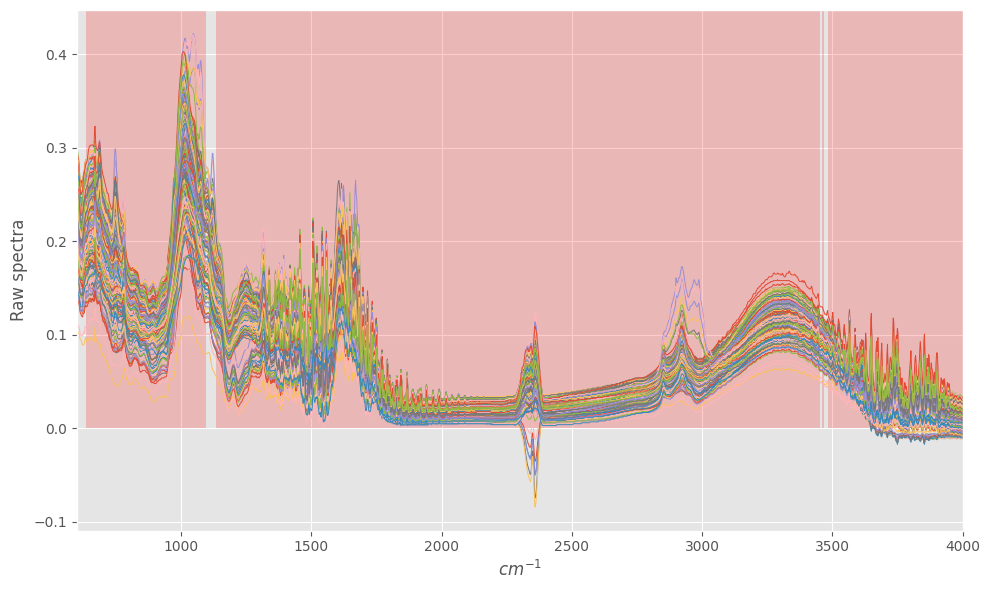

In [289]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection

# Optimize your data operations
ix = np.isin(wl, wl[sorted_ind][:wav])  # Simplify in1d to isin for better clarity and performance

# Create the plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(wl, X_origin.values.T, linewidth = 0.7)  # Add a label for potential legend use
ax.set_ylabel('Raw spectra')  # Use `set_` methods for clarity
ax.set_xlabel('$cm^{-1}$')

# Add highlighted regions
highlight = BrokenBarHCollection.span_where(
    wl, ymin=0, ymax=70, where=ix, facecolor='red', alpha=0.2
)
ax.add_collection(highlight)

# Apply a style and show the plot
plt.style.use('ggplot')  # Apply style at the module level if consistent
plt.xlim(wl[0], wl[-1])
# plt.ylim(0, 70)
plt.tight_layout()  # Optimize layout for better spacing
plt.show()


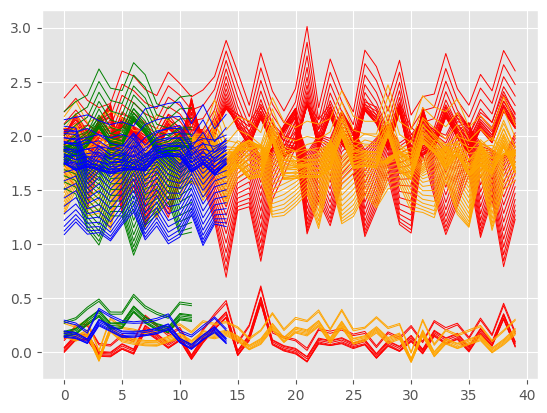

In [290]:
plt.plot(X_train[y_train == 0], color = 'r', linewidth = 0.7)
plt.plot(X_train[y_train == 1], color = 'orange', linewidth = 0.7)
plt.plot(X_train[y_train == 2], color = 'green', linewidth = 0.7)
plt.plot(X_train[y_train == 3], color = 'blue', linewidth = 0.7)
plt.show()

In [305]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

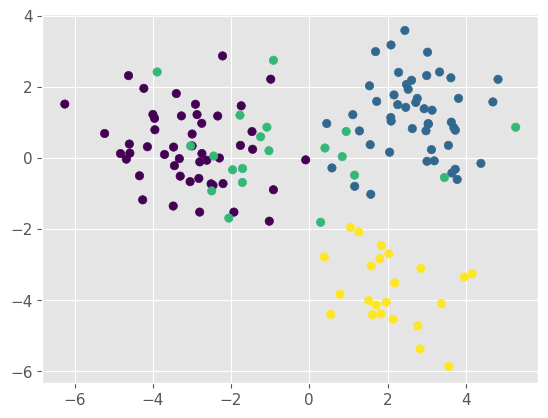

In [306]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# pca = PCA(34)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c = y_train)
plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c = y_test)
plt.show()

In [307]:
import plotly.graph_objects as go
import numpy as np

x1 = X_train_lda[:, 0]
y1 = X_train_lda[:, 1]
z1 = X_train_lda[:, 2]

x2 = X_test_lda[:, 0]
y2 = X_test_lda[:, 1]
z2 = X_test_lda[:, 2]


# Create a 3D scatter plot
fig = go.Figure()
# Add the first scatter trace
fig.add_trace(go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode='markers',
    marker=dict(
        size=5,
        color=y_train,  # Color for the first set
        opacity=0.8
    ),
    # hovertemplate = hover_text_re,
    name='train'  # Name for the legend
))

# Add the second scatter trace
fig.add_trace(go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        size=5,
        color=y_test,  # Color for the second set
        opacity=0.8
    ),
    # hovertemplate = hover_text_than,
    name='test'  # Name for the legend
))

# Set the layout of the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width = 800,
    height = 600,
    title='Multiple 3D Scatter Plots Example'
)

# Show the plot
fig.show()

In [308]:
from sklearn.metrics import accuracy_score

y_pred = lda.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9375

In [309]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
accuracy_score(y_test, y_pred)


0.84375

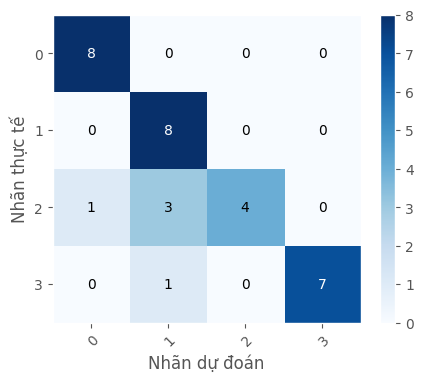

In [296]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, class_names=np.unique(y_test), figsize=(5,4))
plt.rcParams.update({'font.size': 11})
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thực tế")
plt.show()

In [30]:
np.random.seed(0)
res = {}

PCA-SVC

ic| grid.best_params_: {'pca__n_components': 5, 'svc__kernel': 'linear'}




Accuracy score: 0.84375


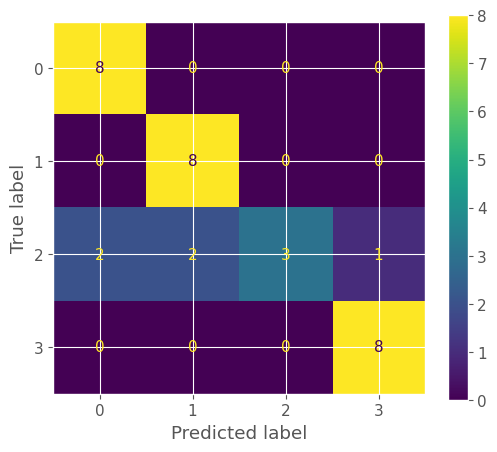

                  0         1         2         3  accuracy  macro avg  \
precision  0.800000  0.800000  1.000000  0.888889   0.84375   0.872222   
recall     1.000000  1.000000  0.375000  1.000000   0.84375   0.843750   
f1-score   0.888889  0.888889  0.545455  0.941176   0.84375   0.816102   
support    8.000000  8.000000  8.000000  8.000000   0.84375  32.000000   

           weighted avg  
precision      0.872222  
recall         0.843750  
f1-score       0.816102  
support       32.000000  


In [302]:
pca = PCA()
svc = SVC()
pipeline = Pipeline(steps=[('pca', pca), ('svc', svc)])
param_grid = {
    'pca__n_components': np.arange(1,42),
    'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0, n_jobs=-1) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
print(report)
# report.T.to_excel(writer, sheet_name=model_name, index=False)
# res[model_name] = accuracy_score(y_test, y_pred)

PCA-GaussNB

ic| grid.best_params_: {'pca__n_components': 11}




Accuracy score: 0.875


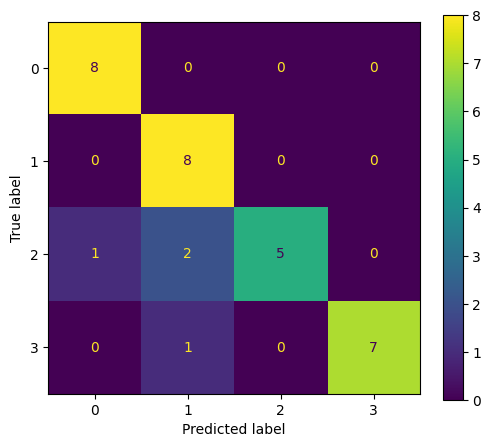

In [ ]:
pca = PCA()
gauss_nb = GaussianNB()
pipeline = Pipeline(steps=[('pca', pca), ('gauss', gauss_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-BernouliNB

ic| grid.best_params_: {'pca__n_components': 19}




Accuracy score: 0.6875


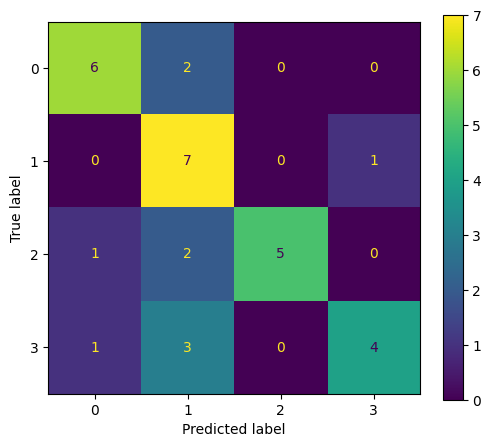

In [ ]:
pca = PCA()
ber_nb = BernoulliNB()
pipeline = Pipeline(steps=[('pca', pca), ('ber', ber_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-RF

ic| grid.best_params_: {'pca__n_components': 10}




Accuracy score: 0.78125


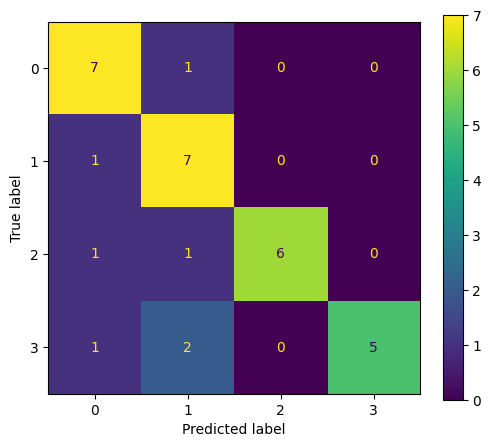

In [ ]:
pca = PCA()
rf = RandomForestClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('rf', rf)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-DT

ic| grid.best_params_: {'pca__n_components': 17}




Accuracy score: 0.75


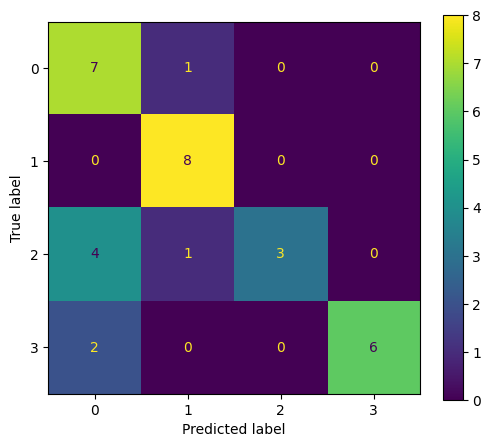

In [ ]:
pca = PCA()
dt = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('dt', dt)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-AdaBoost

c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boos



Accuracy score: 0.625


c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


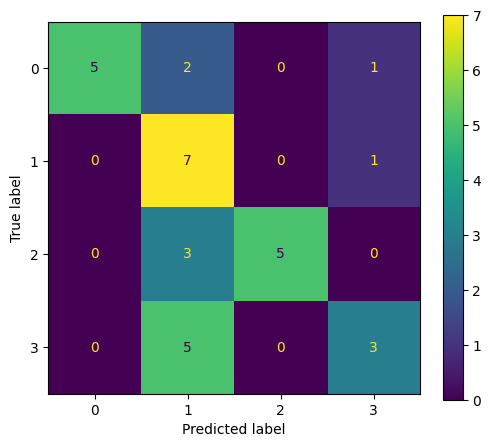

In [ ]:
pca = PCA()
ada = AdaBoostClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('ada', ada)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-GradientBoost

ic| grid.best_params_: {'pca__n_components': 15}




Accuracy score: 0.75


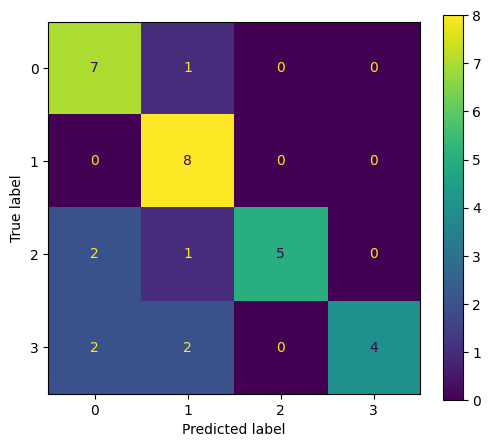

In [ ]:
pca = PCA()
grad_boost = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('grad_boost', grad_boost)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

In [232]:
writer.close()

In [ ]:
res

{'PCA-SVC': 0.96875,
 'PCA-GaussianNB': 0.875,
 'PCA-BernoulliNB': 0.6875,
 'PCA-RandomForestClassifier': 0.78125,
 'PCA-DecisionTreeClassifier': 0.75,
 'PCA-AdaBoostClassifier': 0.625,
 'PCA-GradientBoostingClassifier': 0.75}